# This notebook performs subsequent data clean up and exploratory data analysis

### Import necessary modules

In [1]:
import pandas as pd
import time
from IPython.display import display
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from datetime import datetime
from datetime import date
from dateutil import parser
import collections
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations

%matplotlib inline

### Read the cleaned-up data from directory Data_1

In [2]:
start = time.time()
restaurant_info = pd.read_csv(r'F:\Viraj_work\misc_2\Data_1\restaurant_info.csv', low_memory=False)
user_info = pd.read_csv(r'F:\Viraj_work\misc_2\Data_1\user_info_for_restaurants.csv',low_memory=False)
review_info = pd.read_csv(r'F:\Viraj_work\misc_2\Data_1\review_info_for_restaurants.csv',low_memory=False)
done = time.time()
elapsed = done-start
print('Reading data took {} seconds'.format(round(elapsed, 2)))

Reading data took 204.24 seconds


### Extract information for a particular city - Phoenix is chosen as an example

In [3]:
city = 'Phoenix'
restaurant_info_city = restaurant_info[restaurant_info.city==city]
review_info_city = review_info[review_info.business_id.isin(restaurant_info_city.business_id)]
user_info_city = user_info[user_info.user_id.isin(review_info_city.user_id)]
#rating_martix = pd.pivot_table(review_info_city,index=['user_id'],values=['stars'],columns=['business_id'])

#### Basic characteristics of user/review/restaurant datasets for the city of choice

In [4]:
print('Following is the information about all the relevant datasets for {}\n'.format(city))

print('Review Information\n')
display(restaurant_info_city.info())

print('Restaurant Information\n')
display(review_info_city.info())

print('User Information\n')
display(user_info_city.info())

Following is the information about all the relevant datasets for Phoenix

Review Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 2 to 59352
Data columns (total 8 columns):
Unnamed: 0      3999 non-null int64
business_id     3999 non-null object
categories      3999 non-null object
city            3999 non-null object
name            3999 non-null object
state           3999 non-null object
review_count    3999 non-null int64
stars           3999 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 281.2+ KB


None

Restaurant Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427491 entries, 10 to 4201639
Data columns (total 10 columns):
Unnamed: 0     427491 non-null int64
business_id    427491 non-null object
cool           427491 non-null int64
date           427491 non-null object
funny          427491 non-null int64
review_id      427491 non-null object
stars          427491 non-null int64
text           427491 non-null object
useful         427491 non-null int64
user_id        427491 non-null object
dtypes: int64(5), object(5)
memory usage: 35.9+ MB


None

User Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155786 entries, 1 to 1148087
Data columns (total 23 columns):
Unnamed: 0            155786 non-null int64
average_stars         155786 non-null float64
compliment_cool       155786 non-null int64
compliment_cute       155786 non-null int64
compliment_funny      155786 non-null int64
compliment_hot        155786 non-null int64
compliment_list       155786 non-null int64
compliment_more       155786 non-null int64
compliment_note       155786 non-null int64
compliment_photos     155786 non-null int64
compliment_plain      155786 non-null int64
compliment_profile    155786 non-null int64
compliment_writer     155786 non-null int64
cool                  155786 non-null int64
elite                 10281 non-null object
fans                  155786 non-null int64
friends               155786 non-null object
funny                 155786 non-null int64
name                  155786 non-null object
review_count          155786 n

None

# Exploratory Data Analysis

#### Distribution of ratings - raw data
We can plot the raw data of ratings from the review_info dataset to explore how the ratings are distributed. The plot shows us:
1. 5-star reviews are more than 1-4 star reviews
2. More than half of the reviews imply a positive experience (4-5) stars

This shows that in most of the cases, the reviewers have been satisfied because of the service. However, this might mean that only the "good" restaurants get reviewed often and may not mean the general quality of the restaurants in the city of choice is good. For that we need to explore how the restaurants distributed across the star-rating metric

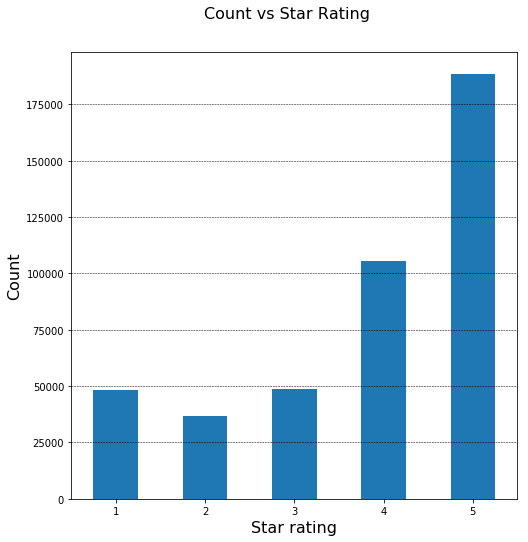

In [5]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
review_info_city.stars.value_counts(sort=False).plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Star rating', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
fig.suptitle('Count vs Star Rating', fontsize=16)
plt.xticks(rotation=0)
fig.subplots_adjust(top=0.9)
plt.savefig('Figure1.png')


#### Distribution of restaurants by star reviews
This plot sheds more light on what we saw in the previous plot. Overall in the city of Phoenix, there are a little over 500-600 restaurants which have an average rating of above 4. However, the majority of the restaurants are rated between 3-4. This in a way confirms what we suspected, that only "good" restaurants are reviewed more often. This can mean either people don't visit the not-so-good restaurants as often or that after people visit these restaurants, they do not feel like writing a review.

Overlall though, we can conclude that in Phoenix, people are satisfied with their restaurant experience - (assumption: above 3 star is satisfied)

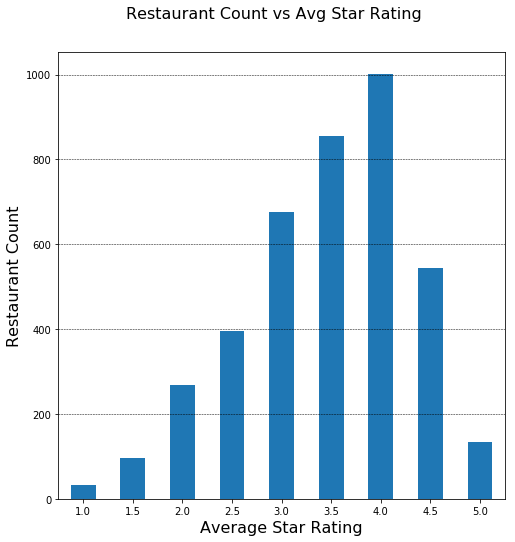

In [6]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
restaurant_info_city.stars.value_counts().sort_index().plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Average Star Rating', fontsize = 16)
ax.set_ylabel('Restaurant Count', fontsize = 16)
fig.suptitle('Restaurant Count vs Avg Star Rating', fontsize=16)
plt.xticks(rotation=0)
fig.subplots_adjust(top=0.9)
plt.savefig('Figure2.png')

#### Ratings per user
This analysis will help us identify how active a user is while reviewing. This makes for an interesting viewing. It is interpreted as follows:
Almost 100000 users have written only ONE review for restaurants in Phoenix. On the other end there are only 20 reviewers who have written more than 100 reviews for restaurants in Phoenix. 

This analysis will be useful in the future because collaborative filtering is based on user characteristics and reliable characteristics about likes and dislikes can be extracted only if a user frequently writes reviews. Getting information from people who have reviewed only once or twice does not make much sense

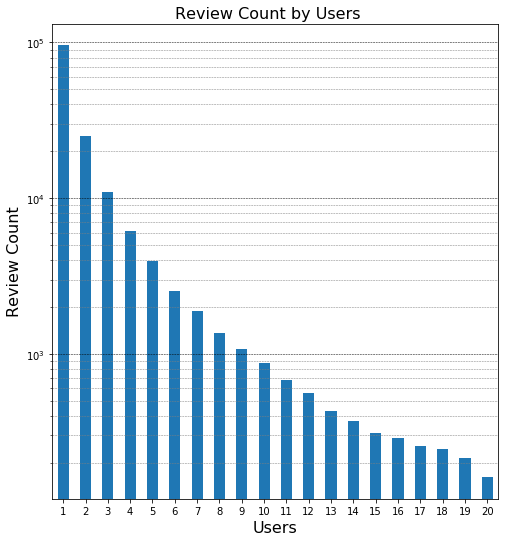

In [7]:
user_review_frequency = review_info_city.groupby('user_id').review_id.agg('count').value_counts().sort_index()
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
user_review_frequency.head(20).plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.5', color='grey')
ax.set_yscale('log')
ax.set_xlabel('Users', fontsize = 16)
ax.set_ylabel('Review Count', fontsize = 16)
fig.suptitle('Review Count by Users', fontsize=16)
plt.xticks(rotation=0)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure3.png')
plt.show()

#### Ratings per year and per month
Exploring this variable will tell us if there are any time trends associated with reviews. Is there a particular period year or period of the year when the reviews are more frequent?

We can see that the number of reviews submitted has definitely increase over time. As far as review month is considered, we do not see a large variation between months, but indeed, during the Nov/Dec holiday season, the frequency of reviews decreases, possibly because people prefer to stay indoors with family

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


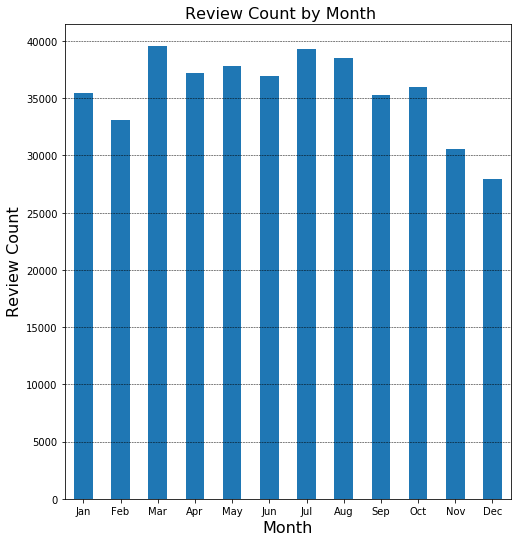

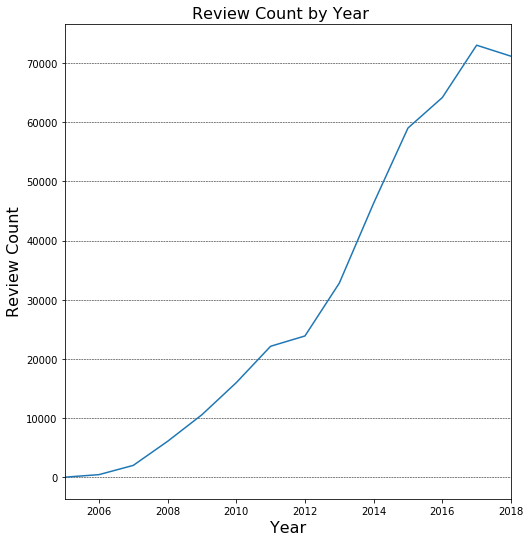

In [8]:
review_info_city['review_month'] = pd.to_datetime(review_info_city.date).dt.month
review_info_city['review_year'] = pd.to_datetime(review_info_city.date).dt.year
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
review_by_month = review_info_city.review_month.value_counts().sort_index()
review_by_month.index = review_by_month.index.to_series().map(month_dict)


fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
review_by_month.plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Month', fontsize = 16)
ax.set_ylabel('Review Count', fontsize = 16)
fig.suptitle('Review Count by Month', fontsize=16)
plt.xticks(rotation=0)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure4.png')
plt.show()

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
review_info_city.review_year.value_counts().sort_index().plot(ax=ax, kind='line')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Review Count', fontsize = 16)
fig.suptitle('Review Count by Year', fontsize=16)
plt.xticks(rotation=0)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure5.png')
plt.show()

#### Segmentation by restaurant Category
Content based filtering is a common way to build a recommendation system. In this case, multiple objects (or in this case, restaurants), will be compared based on their characteristics - or content. In our case, one such characteristic is "category". 

In the next few plots, the trends between category and reviews are explored for the city of Phoenix.

1. The first plot shows how many restaurants serve some typical cuisine. Mexican has the highest with >700 restaurants with Indian being the lowest with only ~50 restaurants. The data is not scrubbed for being exclusive. For example, there might be some restaurants which serve both Mexican and Italian. However, the y-axis will still reflect the correct number of restaurants serving that particular cuisine.

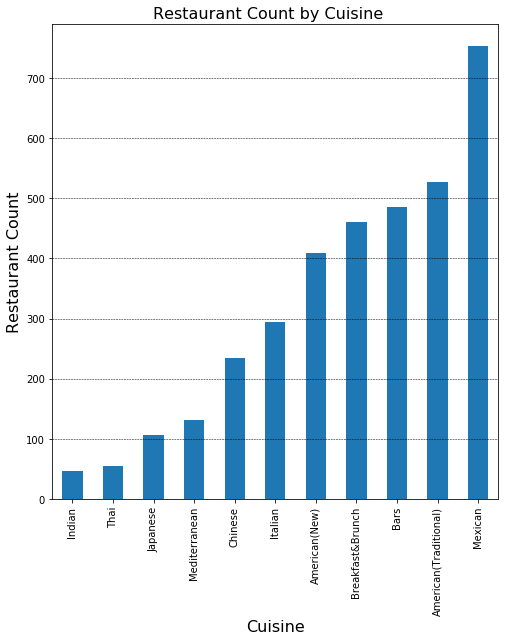

In [9]:
categories = []
for term_1 in restaurant_info_city.categories:
    for term_2 in set(term_1.replace(' ', '').split(',')):
        if term_2 != 'Restaurants':
            categories.append(term_2)
categories
category_counter = collections.Counter(categories)
common_cuisines = ['Mexican', 'Italian', 'Mediterranean', 'Indian', 'Breakfast&Brunch', 'Chinese', 'Thai', 'Japanese', 'Bars', 'American(New)', 'American(Traditional)']
cuisine_ct = [category_counter[k] for k in common_cuisines]
df_cuisine_count = pd.DataFrame(cuisine_ct, index = common_cuisines, columns = ['Count'])


fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
df_cuisine_count['Count'].sort_values().plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Cuisine', fontsize = 16)
ax.set_ylabel('Restaurant Count', fontsize = 16)
fig.suptitle('Restaurant Count by Cuisine', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure6.png')
plt.show()

#### Restaurant count by category - segmented by star rating
We can extract how the restaurants are rated based on the category (or cuisine). The resulting graph has a lot of information whic needs to be unpacked. The general trend we see is expected i.e. a bell shaped plot of ratings between 1-5. With peaks around either 3.5 or 4. 

We can extract an average rating by category as well, which will be seen in the next plot

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


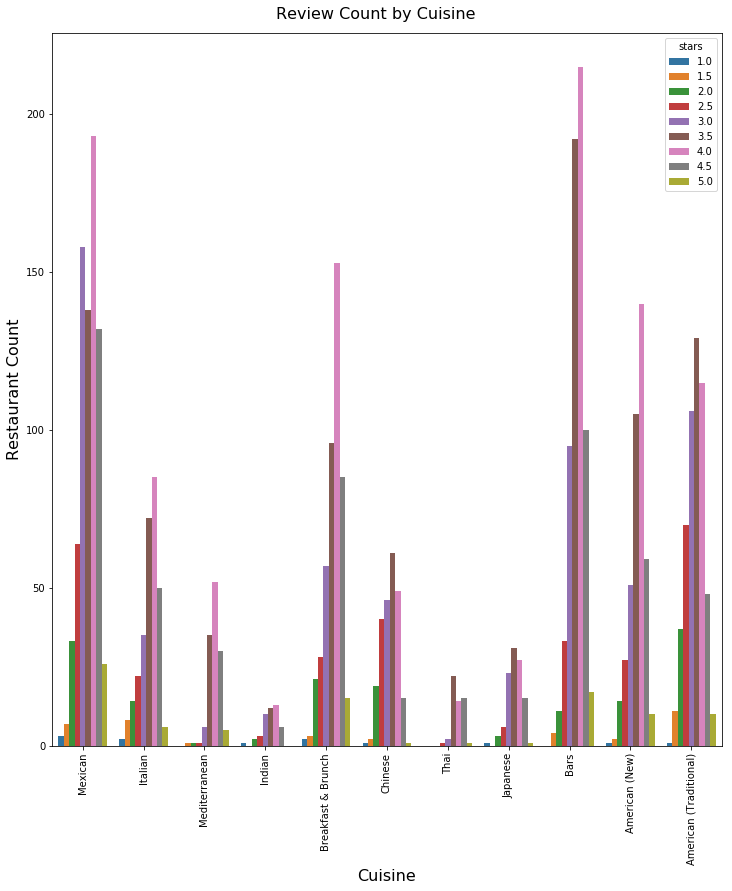

In [10]:
common_cuisines = ['Mexican', 'Italian', 'Mediterranean', 'Indian', 'Breakfast & Brunch', 'Chinese', 'Thai', 'Japanese', 'Bars', 'American (New)', 'American (Traditional)']
col_names=[]
col_names = list(restaurant_info_city.columns)
col_names.append('Cuisine')
csn_df = pd.DataFrame(columns = col_names)
for csn in common_cuisines:
    temp_df = restaurant_info_city[restaurant_info_city.categories.str.contains(csn, regex=False)]
    temp_df['Cuisine'] = csn
    csn_df = csn_df.append(temp_df)

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
ax = sns.countplot(x="Cuisine", hue="stars", data=csn_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Cuisine', fontsize = 16)
ax.set_ylabel('Restaurant Count', fontsize = 16)
fig.suptitle('Review Count by Cuisine', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure7.png')
plt.show()

#### Average Rating by category
As noted before, most of the categories (or cuisine) average between 3.5 to 4 stars. An interesting thing to note here is with the Mediterranean and Thai restaurants - we saw that these two cuisines offer the least choice in terms of number of restaurants. Even so, they are two of the best rated cuisines in the city of Phoenix.

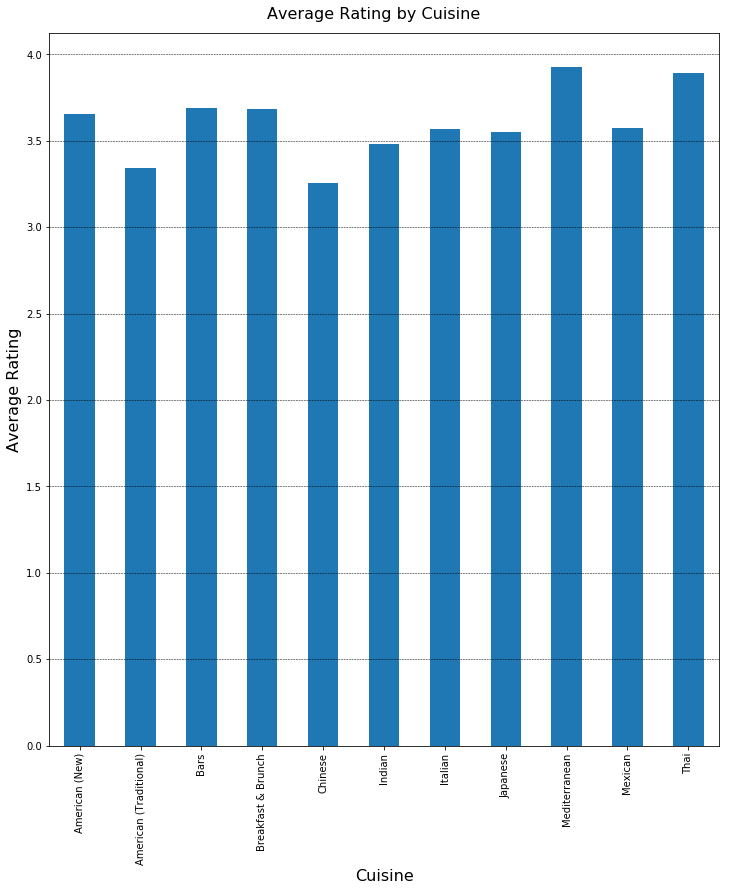

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
csn_df.groupby('Cuisine').stars.mean().plot(ax=ax, kind='bar')
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Cuisine', fontsize = 16)
ax.set_ylabel('Average Rating', fontsize = 16)
fig.suptitle('Average Rating by Cuisine', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure8.png')
plt.show()

#### Review count vs useful

We have explored how the number of ratings vary as a function of number of users. But how many of them are actually helpful and if there are any ooutliers. We can plot the "useful" count vs review count to explore that relationship. Intuitively we expect this to be a positive correlation.

This is what we see in the following plot. We don't see a lot of outliers and the higher the review count, higher is the number of times the reviews are found useful

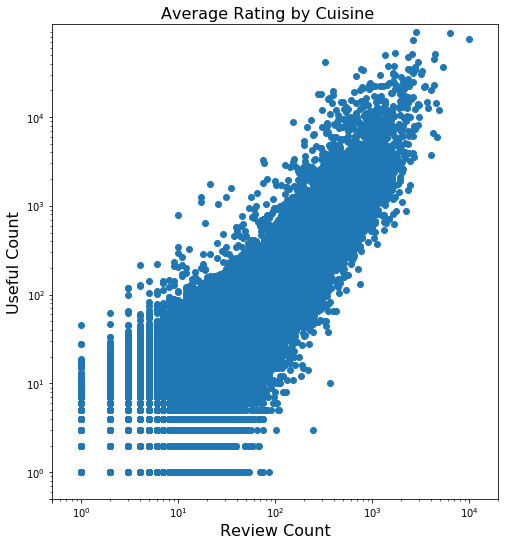

In [12]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.scatter(user_info_city.review_count, user_info_city.useful)
ax.set_xscale('log')
ax.set_xticks([0.5,1,10,100,1000,10000])
ax.set_xlim(0.5,20000)
ax.set_xlabel('Review Count', fontsize = 16)
ax.set_yscale('log')
ax.set_yticks([0.5,1,10,100,1000,10000])
ax.set_ylabel('Useful Count', fontsize = 16)
fig.suptitle('Average Rating by Cuisine', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure9.png')
plt.show()

#### Exploring review content
Now that we have explored the raw data trends, we can take a more detailed look at the review content and if there are any trends which we see in the review text.

In [4]:
tqdm.pandas()
review = review_info_city['text'].progress_apply(lambda x: re.sub('[^a-zA-Z]', ' ', x).lower().split())
ps = PorterStemmer()
review_in_words = review.progress_apply(lambda x: [ps.stem(word) for word in x if not word in set(stopwords.words('english'))])

100%|████████████████████████████████| 427491/427491 [4:51:36<00:00, 24.43it/s]


In [6]:
review_in_words_trunc = review_in_words.iloc[0:1000]
vectorizer = CountVectorizer()
df_similarity = pd.DataFrame(columns=['Pairing', 'Similarity'])
for couple in tqdm(list(combinations(review_in_words_trunc.items(), r=2))):
    A = " ".join(couple[0][1])
    B = " ".join(couple[1][1])
    A_rating = review_info_city.stars.iloc[couple[0][0]]
    B_rating = review_info_city.stars.iloc[couple[1][0]]
    pairing = str(min(A_rating,B_rating))+'_'+str(max(A_rating,B_rating))
    corpus = [A,B]
    count_train = vectorizer.fit_transform(corpus) # this fits on given corpus to create vocabulary
    cos_sim = cosine_similarity(count_train.toarray()[0].reshape(1, -1),count_train.toarray()[1].reshape(1, -1))
    df_similarity = df_similarity.append({'Pairing': pairing, 'Similarity': cos_sim[0][0]}, ignore_index=True)

100%|████████████████████████████████| 499500/499500 [2:09:32<00:00, 64.26it/s]


,Pairing,Similarity
0,1_4,0.019668
1,4_5,0.110680
2,4_5,0.151759
3,4_5,0.061572
4,4_5,0.009597
5,4_5,0.086252
6,4_4,0.054975
7,1_4,0.282731
8,4_4,0.153963
9,4_5,0.171525


In [7]:
df_similarity.columns

Index(['Pairing', 'Similarity'], dtype='object')

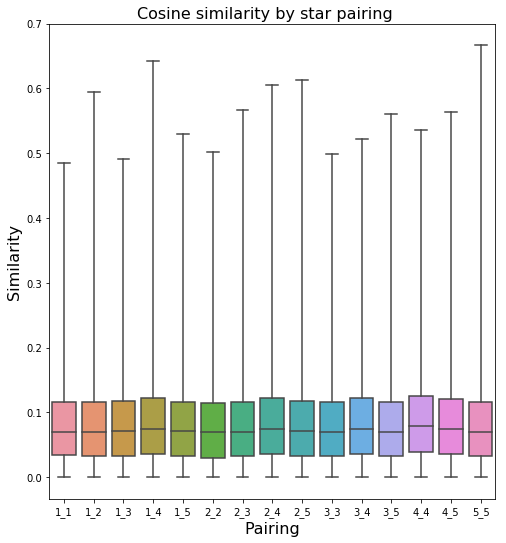

In [73]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax = sns.boxplot(x=df_similarity['Pairing'],y=df_similarity['Similarity'], whis=np.inf)
#ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Pairing', fontsize = 16)
ax.set_ylabel('Similarity', fontsize = 16)
fig.suptitle('Cosine similarity by star pairing', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure10.png')
plt.show()

# Statistical Analysis

One of the obvious tests we can perform on the dataset is ANOVA with the means of star rating by cuisine. This can be done using 2 approaches:
1. In csn_df (derived from restaurant info dataframe), we have a restaurant, its average star rating and the cuisine associated with that particular restaurant. We can perform an ANOVA test on the means of the average star rating
2. We can get the star ratings of the individual reviews from the review_info file, segment it by cuisine and perform an ANOVA test on the mean of those values. This is a more robust check because the data size will be larger and we will be performing ANOVA on the TRUE mean of cuisines rather than mean on average star rating of the restaurants serving that cuisine

#### Mean/Stdev of Average Star rating

In [16]:
display(csn_df.groupby('Cuisine').stars.mean())
display(csn_df.groupby('Cuisine').stars.std())

Cuisine
American (New)            3.656479
American (Traditional)    3.343454
Bars                      3.691904
Breakfast & Brunch        3.684783
Chinese                   3.256410
Indian                    3.478723
Italian                   3.568027
Japanese                  3.551402
Mediterranean             3.927481
Mexican                   3.570955
Thai                      3.890909
Name: stars, dtype: float64

Cuisine
American (New)            0.685968
American (Traditional)    0.775498
Bars                      0.630716
Breakfast & Brunch        0.745785
Chinese                   0.729852
Indian                    0.744235
Italian                   0.805568
Japanese                  0.676194
Mediterranean             0.548151
Mexican                   0.781130
Thai                      0.506357
Name: stars, dtype: float64

In [71]:
import scipy.stats as ss
rating_df = pd.DataFrame(columns = ['Cuisine', 'Rating'])

for csn_ctr in common_cuisines:
    mask = csn_df.Cuisine == csn_ctr
    csn_masked = csn_df[mask]
    review_masked = review_info_city[review_info_city.business_id.isin(list(csn_masked.business_id.values))]
    xtra = {'Cuisine': [csn_ctr]*len(review_masked.stars), 'Rating': list(review_masked.stars)}
    rating_df = rating_df.append(pd.DataFrame(xtra))

samples = [csn_group[1] for csn_group in rating_df.groupby('Cuisine')['Rating']]
f_val, p_val = ss.f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 323.799, p value: 0.000


51.07546357701098
47.504007583540805
36.0


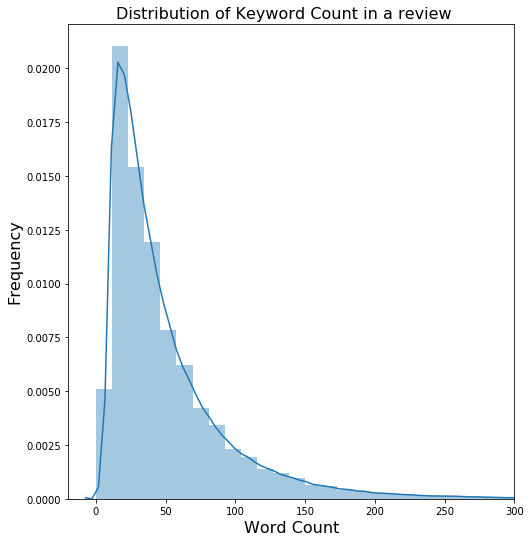

In [141]:
len_review = review_in_words.apply(lambda x: len(x))

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
sns.distplot(len_review)
ax.set_xlim(-20,300)
ax.set_xlabel('Word Count', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)
fig.suptitle('Distribution of Keyword Count in a review', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure11.png')


print(len_review.mean())
print(len_review.std())
print(len_review.median())



100%|███████████████████████████████| 155786/155786 [00:06<00:00, 23441.75it/s]


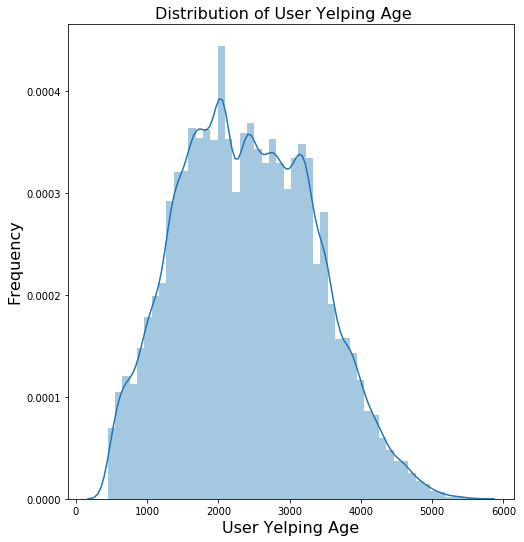

In [140]:
yelping_since = user_info_city['yelping_since'].progress_apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
yelping_since_delta = yelping_since.progress_apply(lambda x: (datetime.now() - x).days)

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
sns.distplot(yelping_since_delta)
ax.set_xlabel('User Yelping Age', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)
fig.suptitle('Distribution of User Yelping Age', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure12.png')

In [139]:
print(yelping_since_delta.mean())
print(yelping_since_delta.std())
print(yelping_since_delta.median())

2404.213427393989
945.265243078272
2372.0
